In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import OneHotEncoder

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow import keras

from IPython.display import clear_output

In [4]:
# carrega os dados
applications = pd.read_excel('Big_Case_-_nubank_v2.1.xlsx', sheet_name='application_data')

In [5]:
# transforma algumas features categóricas em colunas binárias (one-hot-encoding)
applications = pd.concat([applications, pd.get_dummies(applications['residence_duration'], prefix='residence').astype(int)], axis=1)
applications = pd.concat([applications, pd.get_dummies(applications['bank_account_duration'], prefix='bank').astype(int)], axis=1)
applications = pd.concat([applications, pd.get_dummies(applications['facebook_profile_duration'], prefix='fb').astype(int)], axis=1)
applications = pd.concat([applications, pd.get_dummies(applications['home_phone_type'], prefix='phone').astype(int)], axis=1)

# calcula a feature idade do cliente quando é feito o pedido do cartão
applications['age_when_requested'] = (applications['application_when'] - applications['birth_date']).apply(lambda x: x.days//365)

# transforma residence_rent_or_own em binária (1 - rent, 0 - own)
applications['residence_rent_or_own'] = applications['residence_rent_or_own'].astype(int)

# remove algumas colunas de dados irrelevantes 
applications = applications.drop(columns=['first_name', 'middle_initial', 'last_name', 'address_street', 'cep',
                                          'longitude', 'latitude', 'address_state', 'birth_date', 'facebook_profile_duration',
                                          'residence_duration', 'bank_account_duration', 'facebook_gender', 'home_phone_type',
                                          'address_city', 'phone', 'email', 'occupation', 'cpf',])

In [6]:
# carrega os dados de performance de clientes: gasto mensal, tempo como cliente e inadimplência
performance = pd.read_excel('Big_Case_-_nubank_v2.1.xlsx', sheet_name='performance_data')

# Definindo as variáveis Defaulted e Compliant como binárias e opostas
performance['defaulted'] = performance['defaulted'].astype(int)
performance['compliant'] = np.abs(1-performance['defaulted'])

In [7]:
# junta os dados de aplicação do cliente e performance de cada cliente pelo id
clients_data = pd.merge(applications, performance, on='id')

# Arrumando o nome das colunas 
clients_data.columns = clients_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '_').str.replace('+', '')


In [8]:
# Definimos o tempo como cliente 
clients_data['time_as_client'] = (clients_data['customer_until']-clients_data['application_when']).apply(lambda x: np.ceil(x.days/30) if not isinstance(x, type(pd.NaT)) else -1)

# assumimos um efeito lindy para o tempo total de clientes que ainda são clientes (dobro do tempo já gasto até aqui)
clients_data['time_as_client'] = clients_data['time_as_client'].replace([-1], max(clients_data['time_as_client'])*2)

# remove mais uma coluna não utilizada
clients_data = clients_data.drop(columns=['customer_until'])

In [9]:
# Remove Situação impossível: sem gastos porém marcado como inadimplente
indexes_to_filter = clients_data[(clients_data.monthly_spend == 0) & (clients_data.defaulted == 1)].index
clients_data = clients_data.drop(indexes_to_filter)


In [10]:
# Remove dados não formatados corretamente
clients_data = clients_data.replace([-np.inf, np.inf], np.nan)
clients_data = clients_data.dropna()

### Definição do lucro por cliente

Dados que temos o tempo em que um indivíduo permanece como cliente e o seu gasto mensal médio, podemos calucular o lucro cliente como:

### L = (Tempo como Cliente * Gasto Mensal * Taxa do cartão) - (Inadimplente * Gasto Mensal)

Onde Inadimplente é uma variável booleana que representa 1 se o cliente entrou em inadimplência. Assim, estimamos que a perda por um cliente inadimplente é a média do seu gasto mensal

Assumimos, também, um **efeito lindy** para o tempo total que um cliente atual será cliente. Assim, assumindo que os clientes mais longevos tem o cartão há aproximadamente 51 meses, esperamos que eles sejam cliente por mais 51 meses, num total de 102 meses

A taxa do cartão é de 2%

In [11]:
fee = 2/100

# calcula lucro de cada cliente
clients_data['profit'] = (clients_data['time_as_client']*clients_data['monthly_spend']*fee - clients_data['defaulted']*clients_data['monthly_spend'])

### Em caso de calote, quanto é o valor esperado da perda? 

### Por quanto tempo temos o cliente? 

### Qual o lucro esperado por cliente dado inadimplência ou não?

In [12]:
clients_data[['defaulted', 'monthly_spend', 'time_as_client', 'profit']].groupby('defaulted').mean()

,monthly_spend,time_as_client,profit
defaulted,,,
0,1002.469752,90.986618,1818.859016
1,1053.949902,10.404715,-839.305403


In [13]:
clients_data[['defaulted']].mean()

defaulted    0.221064
dtype: float64

#### Ou seja, na média, para clientes adimplentes, esperamos receber aproximadamente 1820 e para clientes inadimplentes, aproximadamente -840

### Problema de negócio:

#### Desenvolver um modelo de decisão para aceitar um pedido de cartão de crédito baseado em informações pessoais e financeiras de cliente

Hoje, aproximadamente 22% dos usuários tornam-se inadimplentes. Sendo assim, utilizando as premissas citadas acima, para cada pedido de cartão, podemos calcular o valor esperado de lucro/cliente como:

$E[L] = (0.78*1818 - 0.22*834) = 1.234$

Se pudermos classificar os novos pedidos de cartão e filtrar aqueles com alta probabilidade de inadimplência, podemos diminuir a taxa de inadimplência de 22% e aumentar a taxa de adimplência de 78%.

Nas métricas de classificação, todos os pedidos classificados como Positivo referem-se a um cliente **COMPLIANT**, ou seja, aquele que **NÃO** deixou de honrar suas dívidas (o oposto de DEFAULT). Assim, temos:

 - True Positive: Cliente classificado como COMPLIANT e que não deixa de pagar a fatura (Receita, $E[X]=1818$)
 - False Positive: Cliente classificado como COMPLIANT mas que vem a deixar de pagar a fatura (Potencial Prejuízo, $E[X] = -840$)
 - True Negative: Cliente classificado como NÃO-COMPLIANT e que de fato viria a deixar de pagar a fatura (Evita-se o prejuízo, $E[X] = 0$)
 - False Negative: Cliente classificado como NÃO-COMPLIANT e que não deixaria de pagar a fatura (Perda de potencial receita, $E[X] = 0$)

Assim, a decisão final se dará no lucro esperado para cada cliente. Para isso serão necessários dois modelos adicionais:
- Um modelo de regressão para estimar o gasto mensal esperado por cliente
- Um modelo classificador para estimar se um cliente será inadimplente ou não

Os clientes classificados como Positive (Profit > 0) receberão cartão, e os classificados como Negative terão seu pedido negado (Profit < 0)

Com essas três informações em mãos, podemos criar o modelo final. A matrix de confuão a seguir demonstra os valores esperados para cada decisão

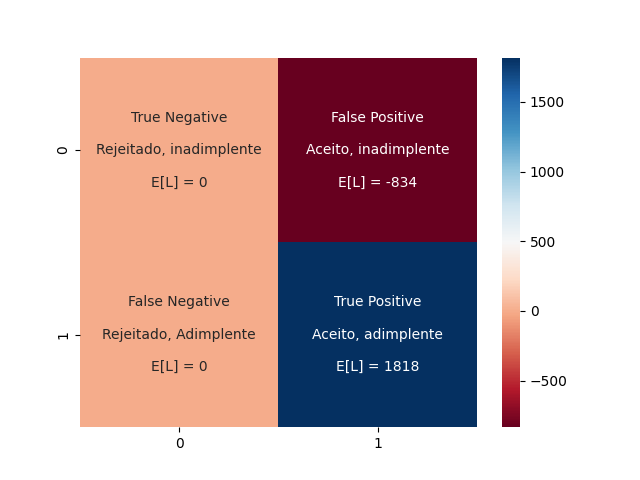

In [43]:
clients = deepcopy(clients_data)

#Definindo novas features

# Dinheiro disponível para o cliente da sua renda mensal após pagar o aluguel
clients['free_cash_flow'] = clients['monthly_income']-clients['monthly_rent']

# Razão entre a linha de crédito aprovada e requisitada
clients['app_req_ratio'] = clients['credit_line_approved']/clients['credit_line_requested']

# Razão entre renda mensal e linha de crédito aprovada
clients['approved_income_ratio'] = clients['credit_line_approved']/clients['monthly_income']

In [44]:
personal_data = [
    'age_when_requested', 'residence_1_2_years', 'residence_3_years', 
    'residence_6_months_or_less', 'residence_7_12_months',]
                  
bank_data = [
    'bank_1_2_years','bank_3_years', 'bank_6_months_or_less', 'bank_7_12_months',]

financial_data = [
    'monthly_income', 'monthly_rent', 'residence_rent_or_own',
    'free_cash_flow', 'approved_income_ratio']

credit_score_data = [
    'score_tu', 'score_fico_money', 'score_lexisnexis', 'score_serasa', 
    'score_unit4', 'credit_line_requested', 'credit_line_approved','app_req_ratio']

target = ['compliant', 'monthly_spend', 'time_as_client', 'profit']

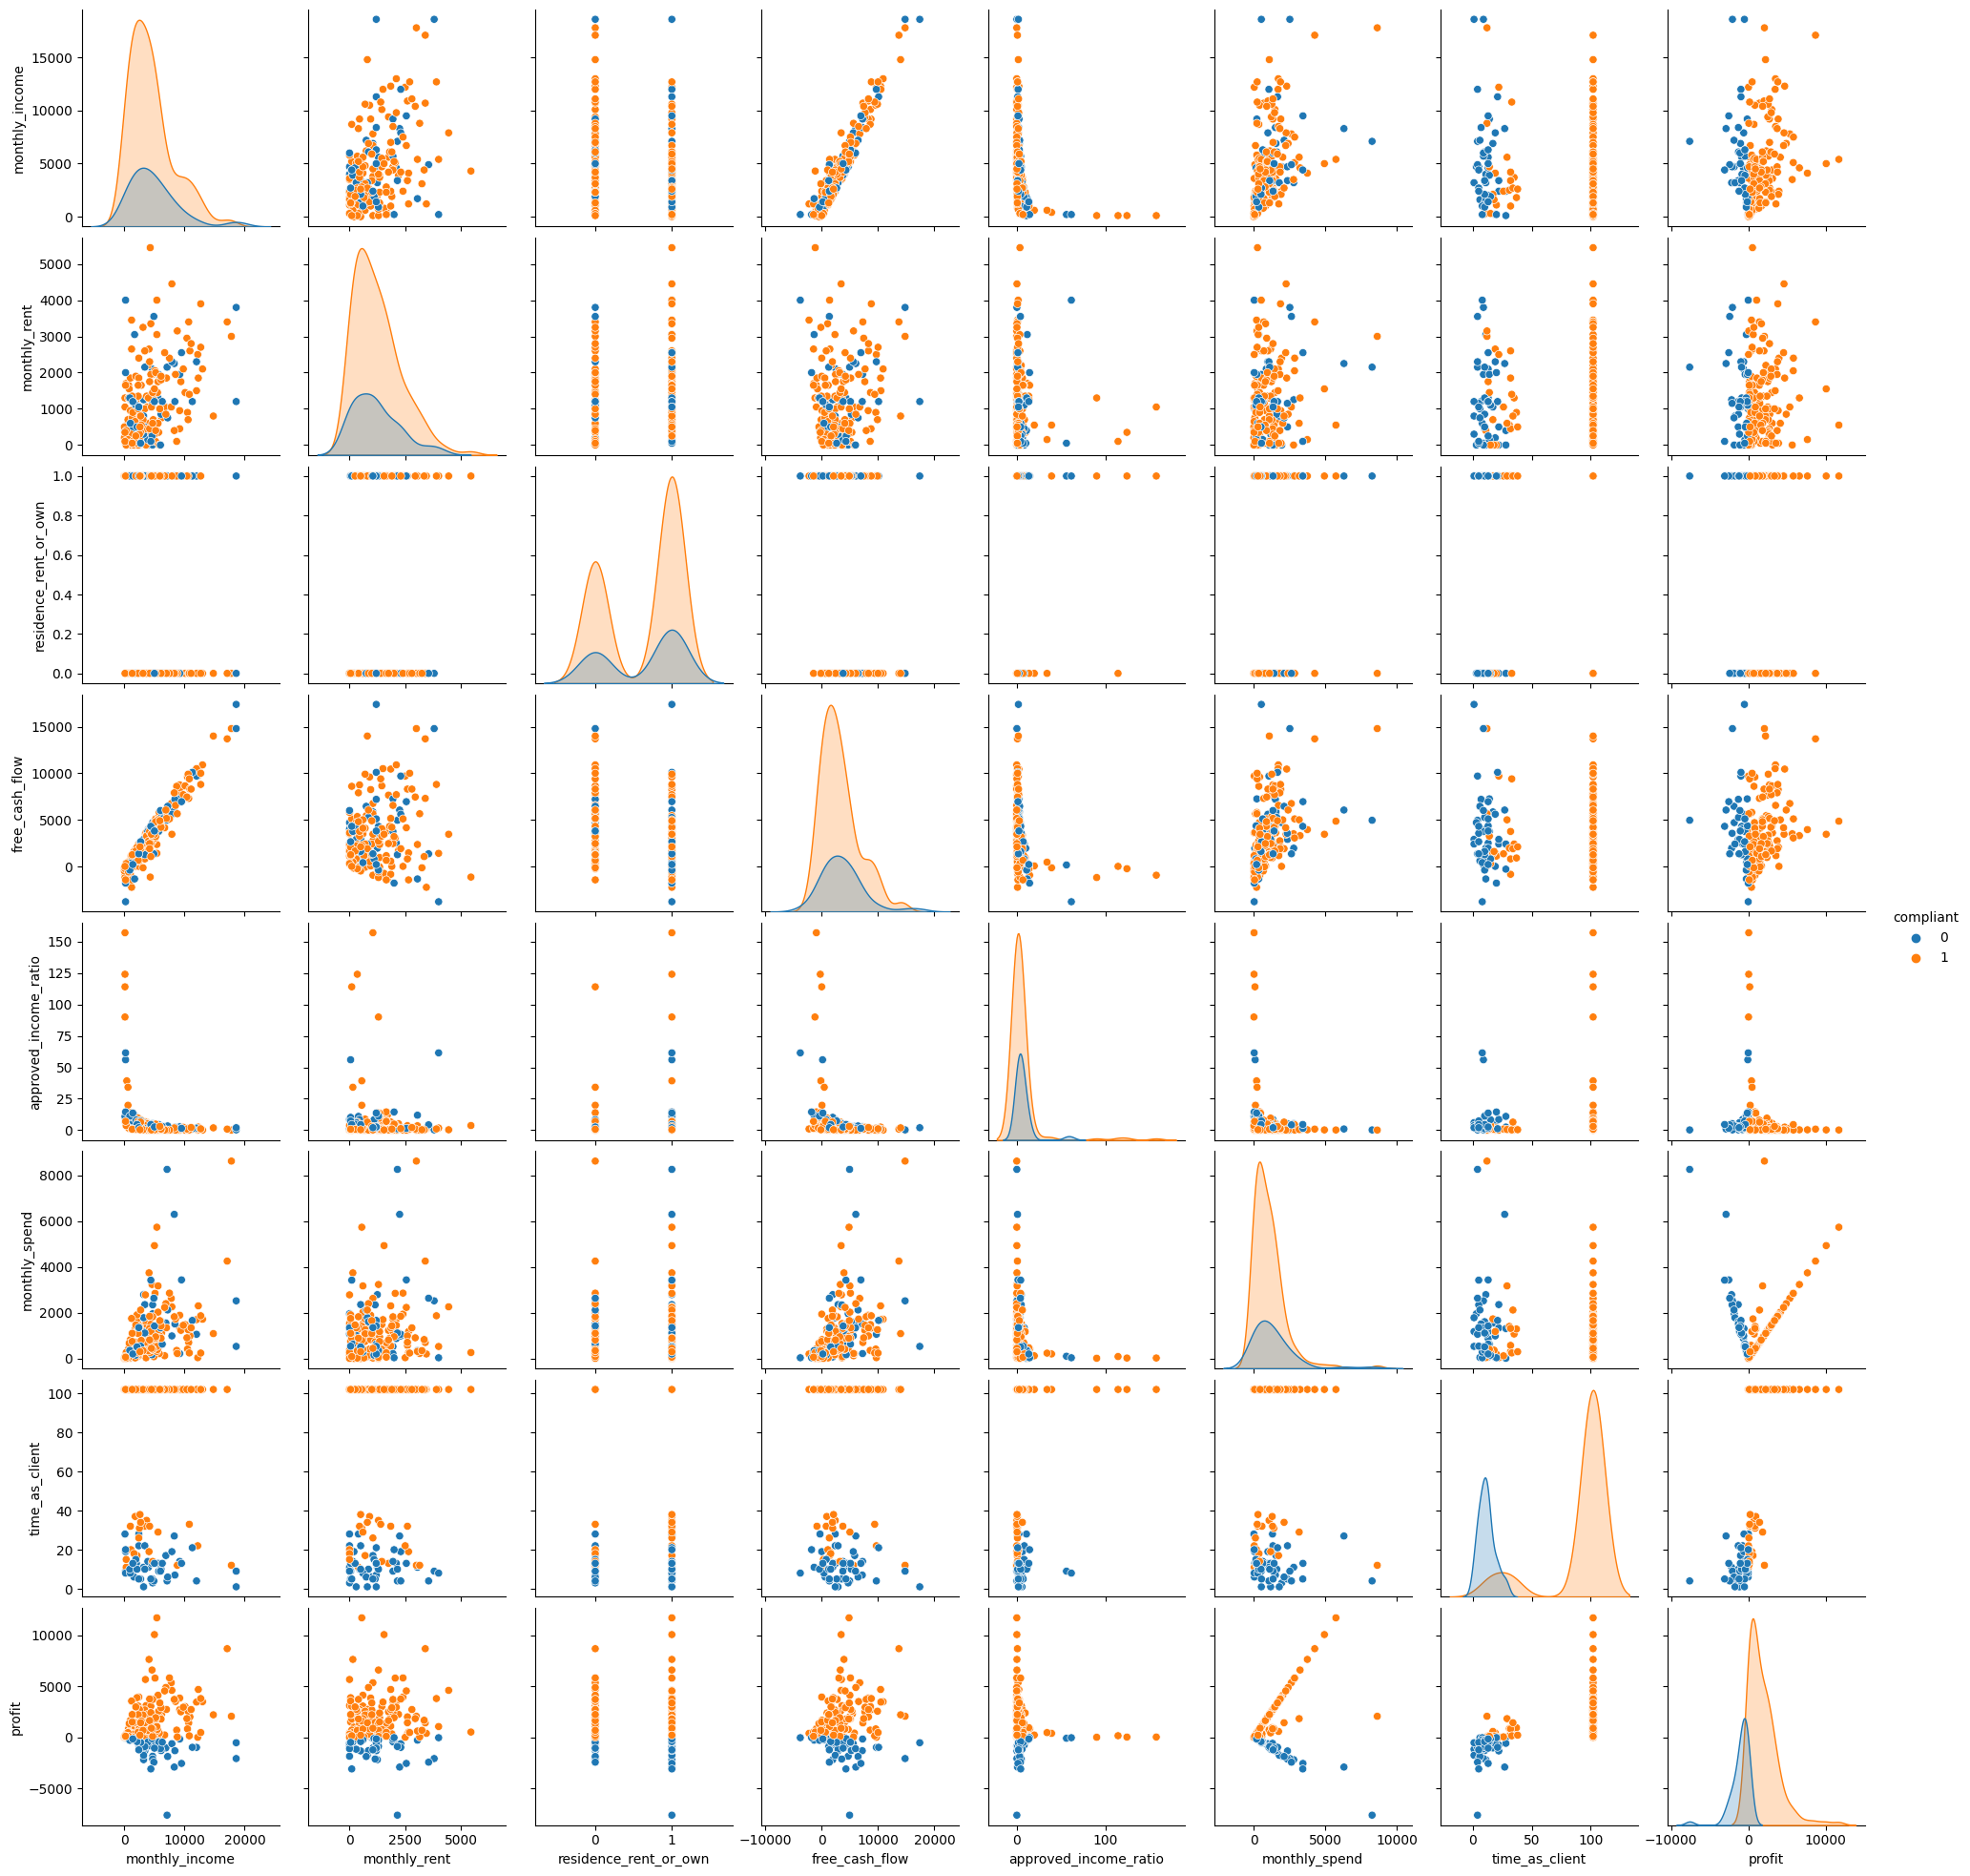

In [15]:
sns.pairplot(clients.sample(200)[financial_data + target], hue='compliant')
plt.savefig('financial_data_pairplot.png')

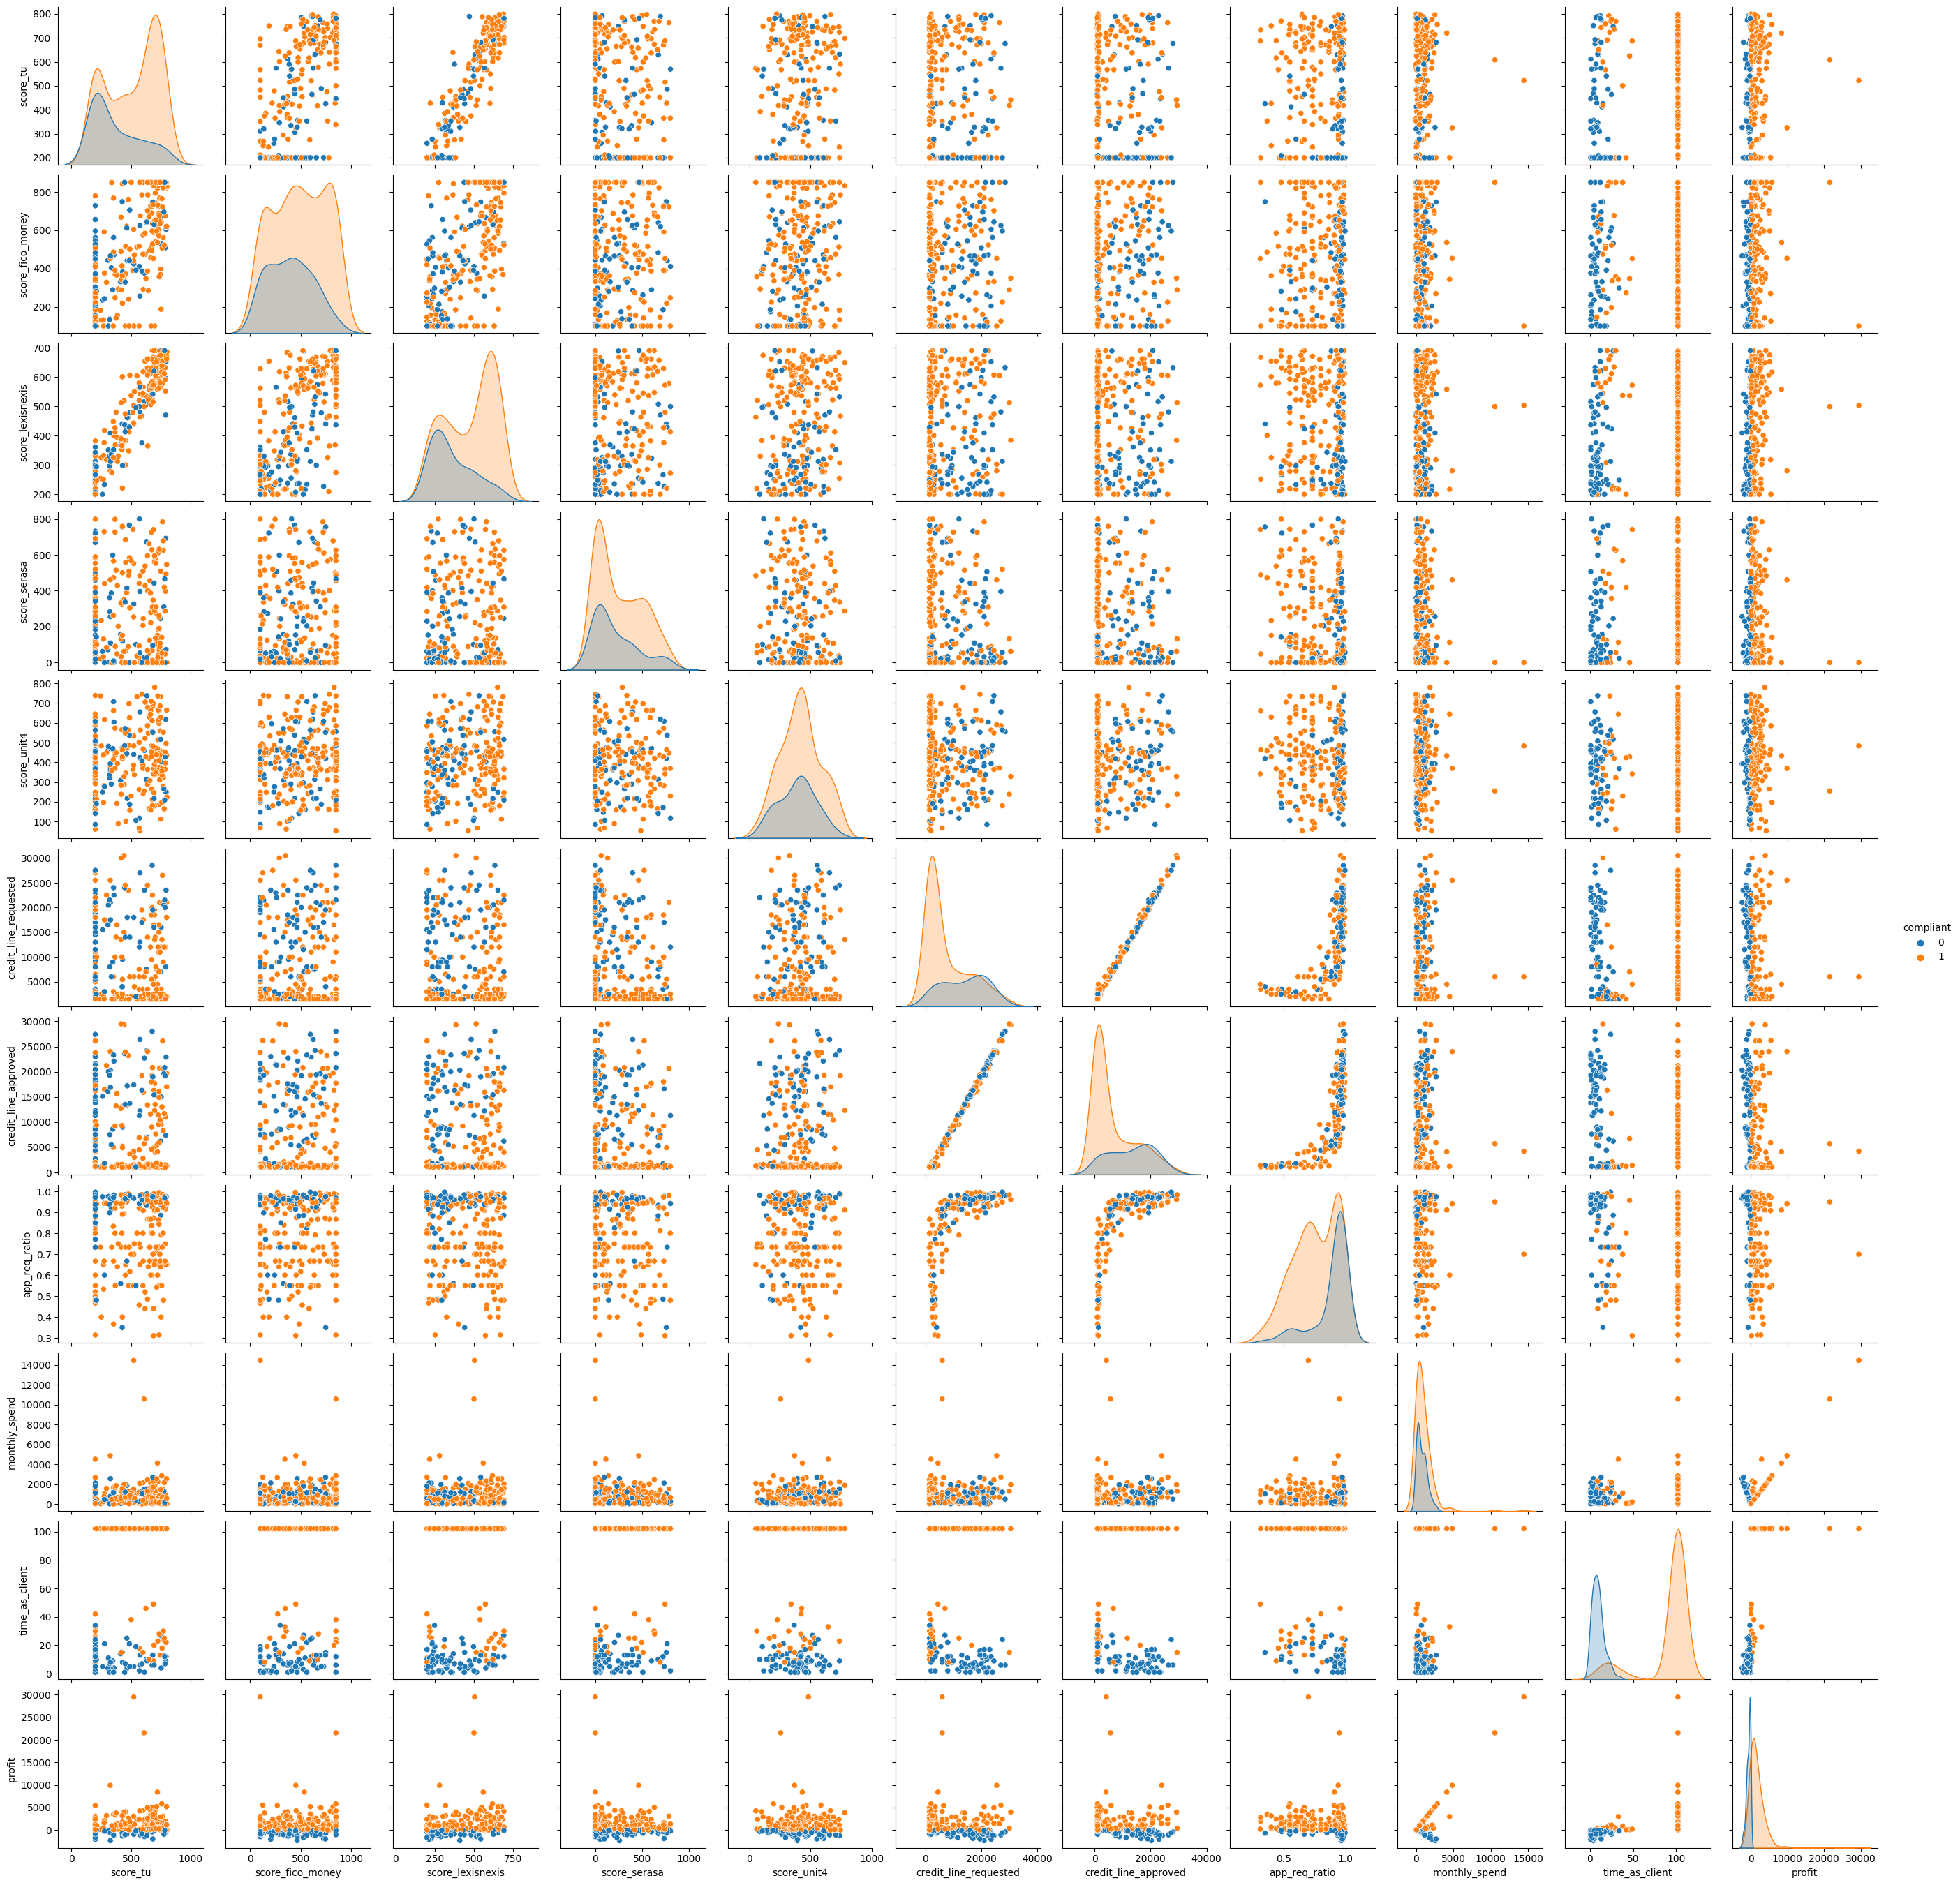

In [16]:
sns.pairplot(clients.sample(250)[credit_score_data + target], hue='compliant')
plt.savefig('credit_score_data_pairplot.png')


In [45]:
# Features selecionadas para o modelo final
selected_features = [
    'residence_1_2_years', 'residence_3_years', 
    'residence_6_months_or_less', 'residence_7_12_months',
    'bank_1_2_years','bank_3_years', 'bank_6_months_or_less', 'bank_7_12_months',
    'monthly_income', 'monthly_rent', 'residence_rent_or_own',
    'free_cash_flow', 'approved_income_ratio',
    'score_tu', 'score_fico_money', 'score_lexisnexis', 'score_serasa', 
    'score_unit4', 'credit_line_requested', 'credit_line_approved','app_req_ratio',
]

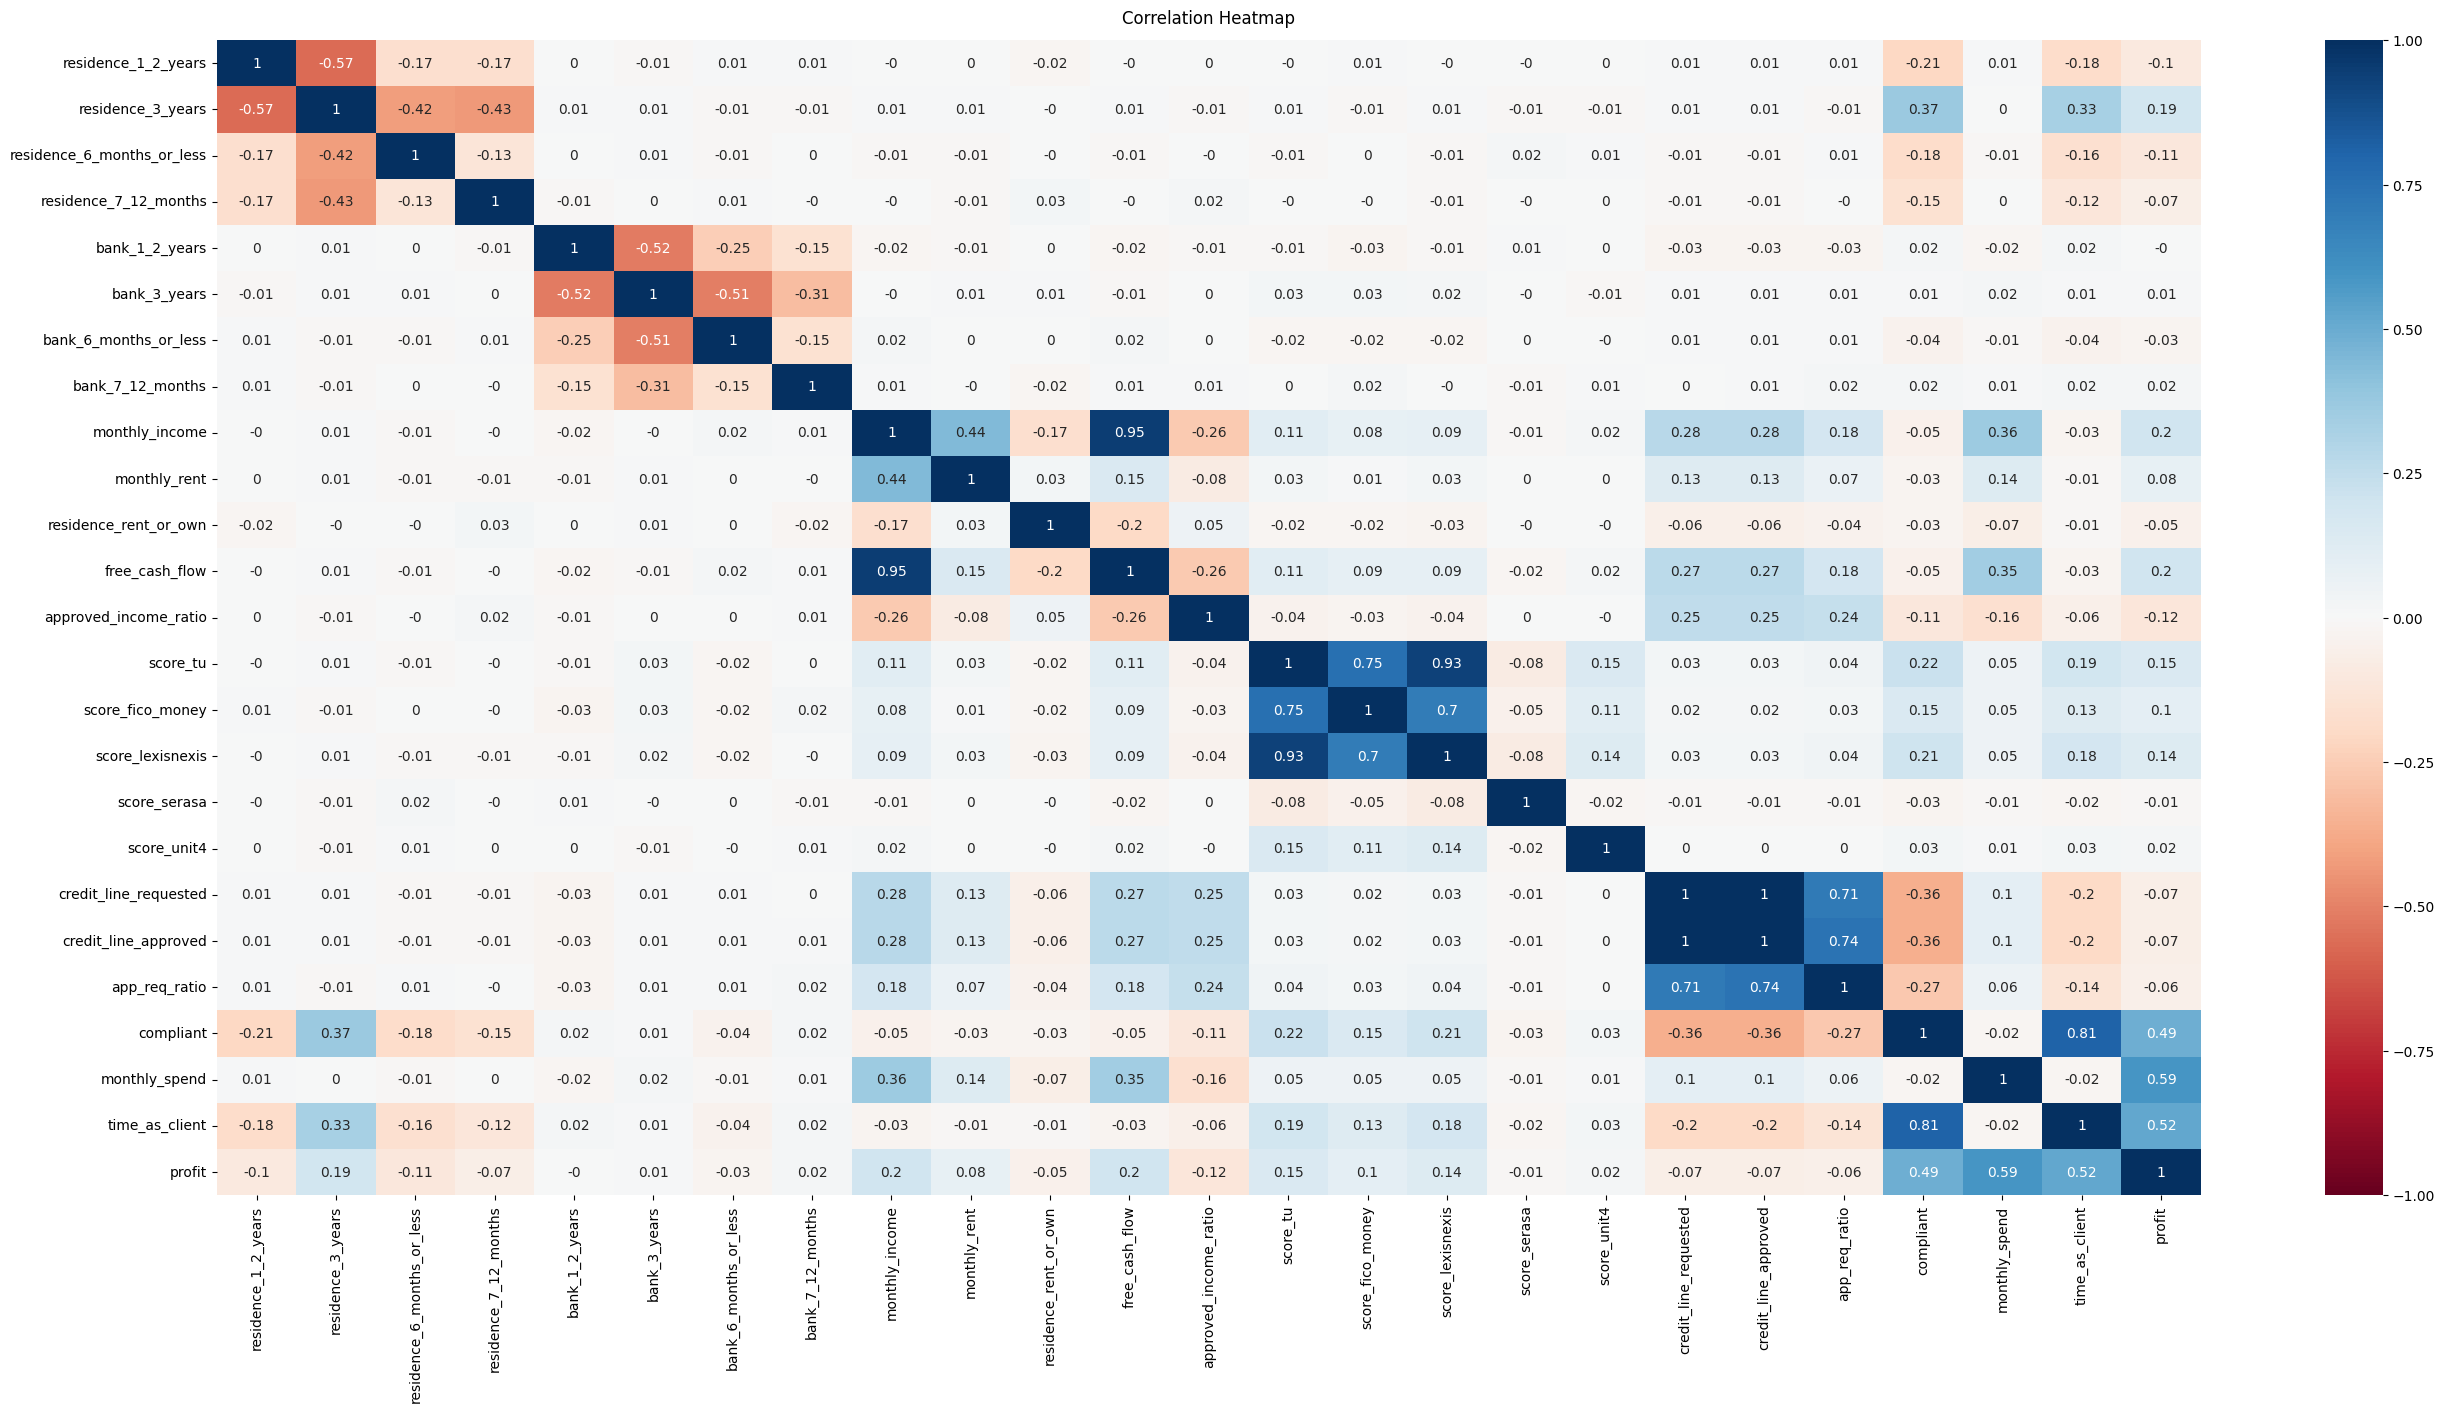

In [46]:
# Increase the size of the heatmap.
plt.figure(figsize=(32, 15))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(clients[selected_features+target].corr().round(2), vmin=-1, vmax=1, annot=True, cmap='RdBu')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [47]:
# Prepara os datasets finais de treino e teste, separado do treino (1000 exemplos)

final_df = deepcopy(clients[selected_features+target])
final_df = final_df.replace([-np.inf, np.inf], np.nan)
final_df = final_df.dropna()
final_df.to_json('final_data.json')

testing_df = final_df.sample(1000, random_state=12)
train_df = final_df.drop(testing_df.index)

testing_df.to_json('test_data.json')
train_df.to_json('train_data.json')